In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [137]:
data_path = "COST-2015-08-03.parquet"
data = pd.read_parquet(data_path)
start_investment = 10000

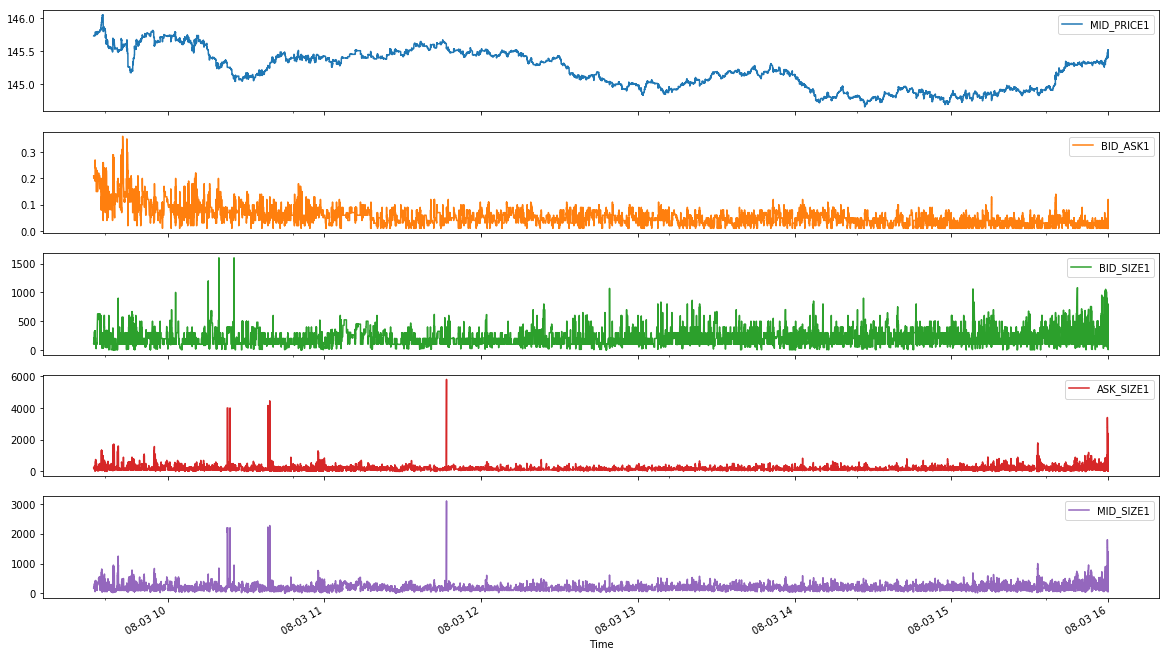

In [138]:
data.loc[:, 'MID_PRICE1'] = 0.5 * (data["BID_PRICE1"] + data["ASK_PRICE1"])
data.loc[:, 'MID_SIZE1'] = 0.5 * (data["BID_SIZE1"] + data["ASK_SIZE1"])
data.loc[:, 'BID_ASK1'] = data["ASK_PRICE1"] - data["BID_PRICE1"]
data.loc[:, ['MID_PRICE1', 'BID_ASK1', 'BID_SIZE1', 'ASK_SIZE1', 'MID_SIZE1']].iloc[100:,:].plot(subplots = True, figsize = (20, 12));

In [139]:
def MA_technical(data, l, s, b):
    dt = data['MID_PRICE1'].values
    return moving_average_signal(dt, l, s, b)

def MP_technical(data, l, s, b):
    dt = data['MID_PRICE1'][-(l+1):]
    dt = (dt.diff() / dt.shift())[1:]
    return moving_average_signal(dt, l, s, b)

def MV_technical(data, l, s, b):
    dt = data['MID_SIZE1'][-(l+1):]
    dt = (dt.diff() / dt.shift())[1:]
    return moving_average_signal(dt, l, s, b)

def RSI_technical(dt, l, s, b):
    dt.loc[:, 'PREVIOUS_PRICE1'] = dt['MID_PRICE1'].shift(1)
    dt.loc[:, 'UP_PRICE'] = np.where(dt['MID_PRICE1'] <= dt['PREVIOUS_PRICE1'], dt['PREVIOUS_PRICE1']-dt['MID_PRICE1'], 0)
    dt.loc[:, 'DOWN_PRICE'] = np.where(dt['MID_PRICE1'] >= dt['PREVIOUS_PRICE1'], dt['MID_PRICE1']-dt['PREVIOUS_PRICE1'], 0)
    dt.loc[:, 'CUM_UP_PRICE'] = dt['UP_PRICE'].cumsum()
    dt.loc[:, 'CUM_DOWN_PRICE']= dt['DOWN_PRICE'].cumsum()
    dt.loc[:, 'RSI'] = 100 - 100/(1+(dt['CUM_UP_PRICE'] - dt['CUM_UP_PRICE'].shift(14))/(dt['CUM_DOWN_PRICE'] - dt['CUM_DOWN_PRICE'].shift(14)))
    dt.loc[:, 'RSI'] = np.where(dt['RSI'] <= 30, 1, np.where(dt['RSI'] >= 70, -1, 0))
    return dt.iloc[len(dt)-1,:]['RSI']

def moving_average_signal(data, l, s, b):
    try:
        ma_ratio = np.mean(data[-s:])/np.mean(data[-l:])
    except:
        ma_ratio = 0
    return 1 if ma_ratio > (1 + b) else (-1 if ma_ratio < (1 - b) else 0)

In [140]:
def add_signals(signal_data, data, signal_func_dict, l, s, b):
    for i, time in enumerate(signal_data.index):
        dt = data.loc[:time,:]
        for signal_name, signal_func in signal_func_dict.items():
            signal_data.loc[time, signal_name] = signal_func(dt, l, s, b)
    signal_data.loc[signal_data.index.strftime('%H:%M:%S') >= "15:50:00",:] = -1
    return signal_data

signal_df = pd.DataFrame(index = pd.date_range(start = np.min(data.index), end = np.max(data.index), freq = '30S'))
signal_df = add_signals(signal_df, data, {'MA': MA_technical, 'MP': MP_technical, 'MV': MV_technical, 'RSI':RSI_technical},
                    60, 30, 0.0001)

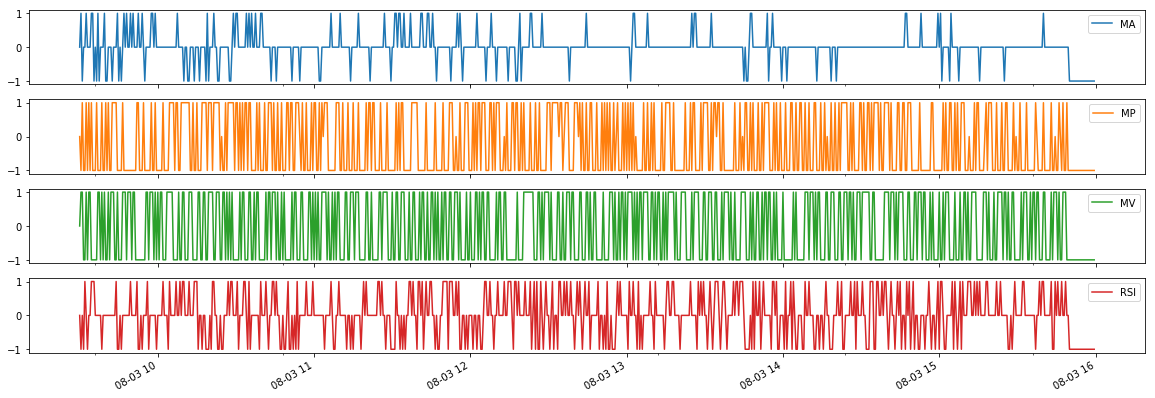

In [141]:
signal_df.plot(subplots = True, figsize = (20, 7));

In [142]:
def get_portfolio(data, signal, delay_s = 0):
    portfolio = pd.DataFrame(index = signal.index, columns = ['Cash', 'Security'])
    cash, security, value = np.array([0] * portfolio.shape[0]), np.array([0] * portfolio.shape[0]), np.array([0] * portfolio.shape[0])
    exec_time = (portfolio.index + pd.to_timedelta(delay_s, unit='s')).values
    cash[0], security[0], value[0] = start_investment, 0, start_investment
    for i, time in enumerate(portfolio.index[1:]):
        i = i+1
        last_data = data.loc[:exec_time[i], :].iloc[-1,:]
        if signal[time] == 0:
            cash[i], security[i] = cash[i-1], security[i-1]
        elif signal[time] == 1:
            security_bought = min(int(cash[i-1]/last_data['ASK_PRICE1']), last_data['ASK_SIZE1'])
            cash[i], security[i] = cash[i-1] - security_bought*last_data['ASK_PRICE1'], security[i-1] + security_bought
        else:
            security_sold = min(security[i-1], last_data['BID_SIZE1'])
            cash[i], security[i] = cash[i-1] + security_sold*last_data['BID_PRICE1'], security[i-1] - security_sold
            
        price = last_data['BID_PRICE1']
        value[i] = cash[i] + security[i]*last_data['BID_PRICE1']
    
    portfolio.loc[:, 'Cash'] = cash
    portfolio.loc[:, 'Security'] = security
    portfolio.loc[:, 'Value'] = value
    return portfolio

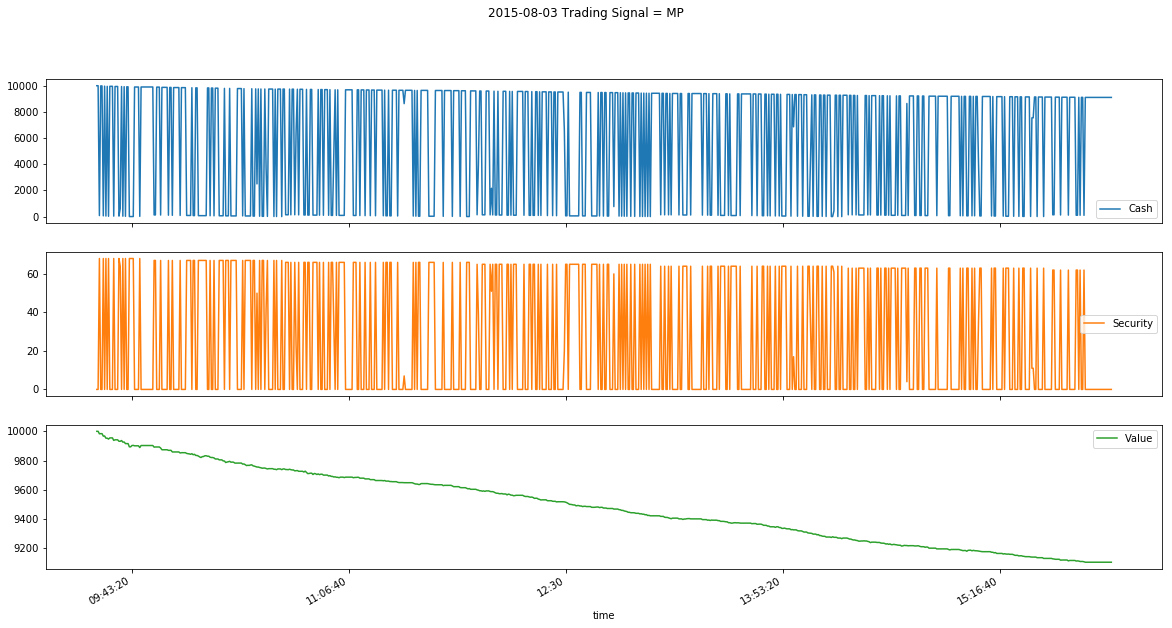

In [143]:
def plot_portfolio(data, signal_df, signal_name, delay = 0):
    portfolio = get_portfolio(data, signal_df[signal_name], delay)
    title = str(portfolio.index.date[0]) + ' Trading Signal = ' + signal_name
    portfolio.index = portfolio.index.time
    portfolio.plot(subplots = True, figsize = (20, 10));
    plt.suptitle(title)

plot_portfolio(data, signal_df, 'MP')

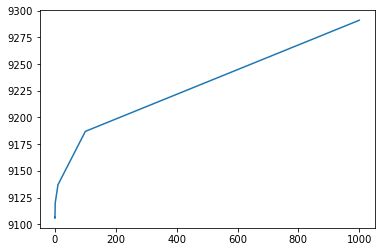

In [144]:
delays = 10.0 ** np.arange(-4, 4)
final_values = list(map(lambda x: get_portfolio(data, signal_df['MP'], x).iloc[-1,2], delays))
plt.plot(list(map(lambda x: str(x), delays)), final_values)

# Added by Silvi

In [145]:
def plot_portfolio(signal_name, delay):
    cash_list = [1000000]
    security_list = [0]
    i = 1
    for time in signal_df.index:
        cash = cash_list[i-1]
        security = security_list[i-1]
        df = data.loc[:(time + pd.to_timedelta(delay, unit='s')), :].iloc[-1,:]
        if signal_df[signal_name][time] == 1:
            if df['ASK_SIZE1']*df['ASK_PRICE1'] >= cash:
                security = security + cash/df['ASK_PRICE1']
                cash = 0
            else:
                cash = cash - df['ASK_SIZE1']*df['ASK_PRICE1']
                security = security + df['ASK_SIZE1']
                if df['ASK_SIZE2']*df['ASK_PRICE2'] >= cash:
                    security = security + cash/df['ASK_PRICE2']
                    cash = 0
                else:
                    cash = cash - df['ASK_SIZE2']*df['ASK_PRICE2']
                    security = security + df['ASK_SIZE2']
                    if df['ASK_SIZE3']*df['ASK_PRICE3'] >= cash:
                        security = security + cash/df['ASK_PRICE3']
                        cash = 0
                    else:
                        cash = cash - df['ASK_SIZE3']*df['ASK_PRICE3']
                        security = security + df['ASK_SIZE3']
                        if df['ASK_SIZE4']*df['ASK_PRICE4'] >= cash:
                            security = security + cash/df['ASK_PRICE4']
                            cash = 0
                        else:
                            cash = cash - df['ASK_SIZE4']*df['ASK_PRICE4']
                            security = security + df['ASK_SIZE4']
                            if df['ASK_SIZE5']*df['ASK_PRICE5'] >= cash:
                                security = security + cash/df['ASK_PRICE5']
                                cash = 0
                            else:
                                cash = cash - df['ASK_SIZE5']*df['ASK_PRICE5']
                                security = security + df['ASK_SIZE5']
        if signal_df[signal_name][time] == -1:
            if df['BID_SIZE1'] >= security:
                security = 0
                cash = cash + security*df['BID_PRICE1']
            else:
                cash = cash + df['BID_SIZE1']*df['BID_PRICE1']
                security = security - df['BID_SIZE1']
                if df['BID_SIZE2'] >= security:
                    security = 0
                    cash = cash + security*df['BID_PRICE2']
                else:
                    cash = cash + df['BID_SIZE2']*df['BID_PRICE2']
                    security = security - df['BID_SIZE2']
                    if df['BID_SIZE3'] >= security:
                        security = 0
                        cash = cash + security*df['BID_PRICE3']
                    else:
                        cash = cash + df['BID_SIZE3']*df['BID_PRICE3']
                        security = security - df['BID_SIZE3']
                        if df['BID_SIZE4'] >= security:
                            security = 0
                            cash = cash + security*df['BID_PRICE4']
                        else:
                            cash = cash + df['BID_SIZE4']*df['BID_PRICE4']
                            security = security - df['BID_SIZE4']
                            if df['BID_SIZE5'] >= security:
                                security = 0
                                cash = cash + security*df['BID_PRICE5']
                            else:
                                cash = cash + df['BID_SIZE5']*df['BID_PRICE5']
                                security = security - df['BID_SIZE5']
        security_list.append(security)
        cash_list.append(cash)
        i = i + 1
    portfolio = pd.DataFrame()
    portfolio['cash'] = cash_list
    portfolio['security'] = security_list
    portfolio.plot(subplots=True, figsize = (20, 10))
    return (portfolio.iloc[-1, :]['cash'] - portfolio.iloc[0, :]['cash'])/portfolio.iloc[0, :]['cash']

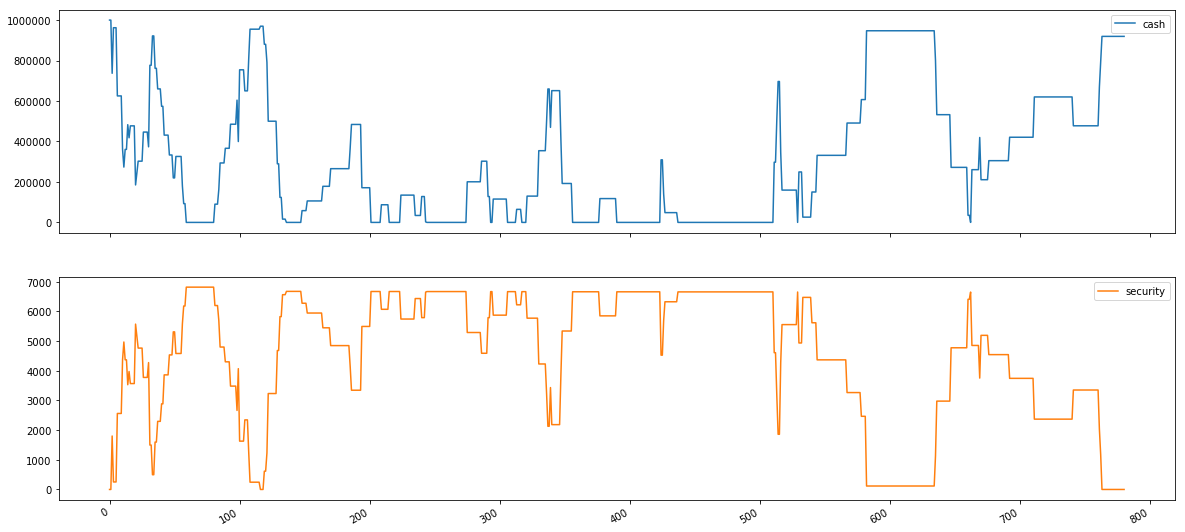

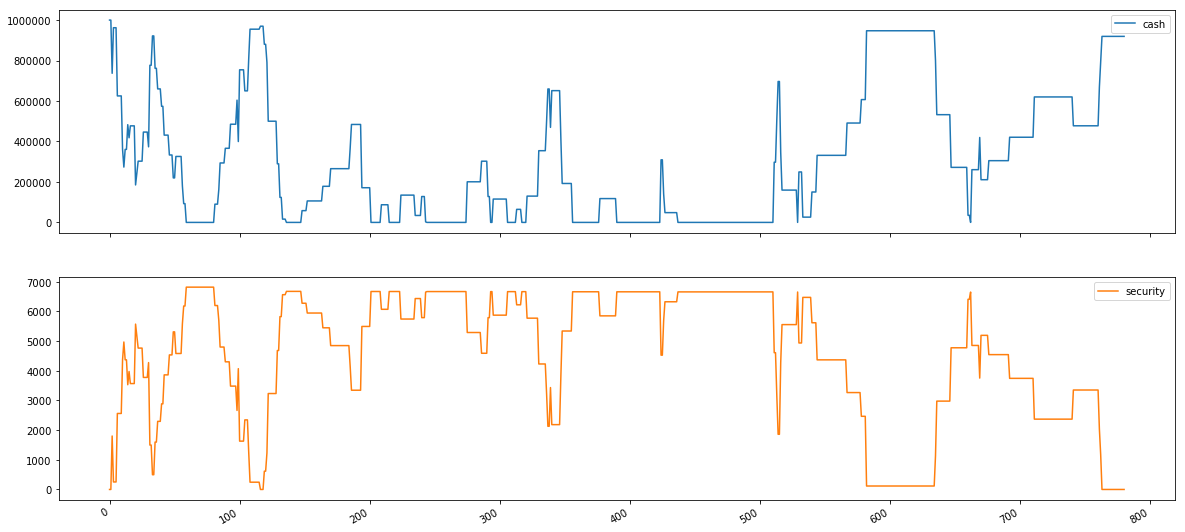

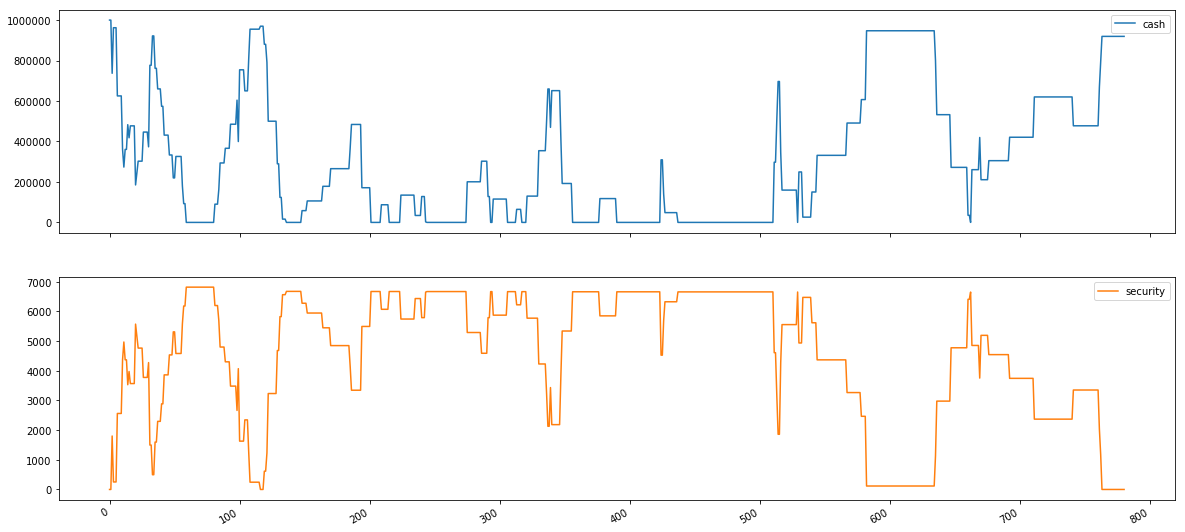

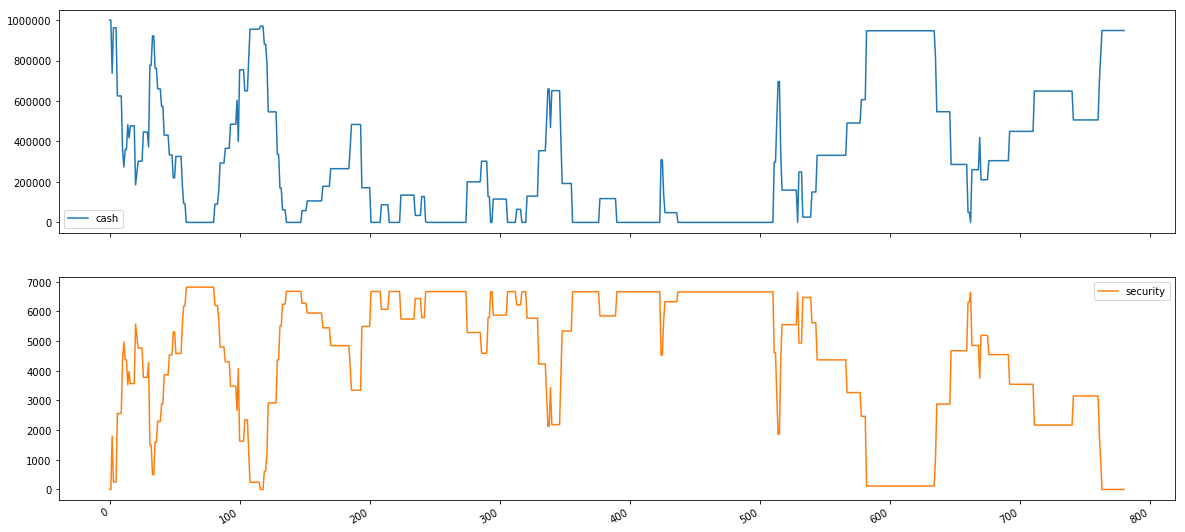

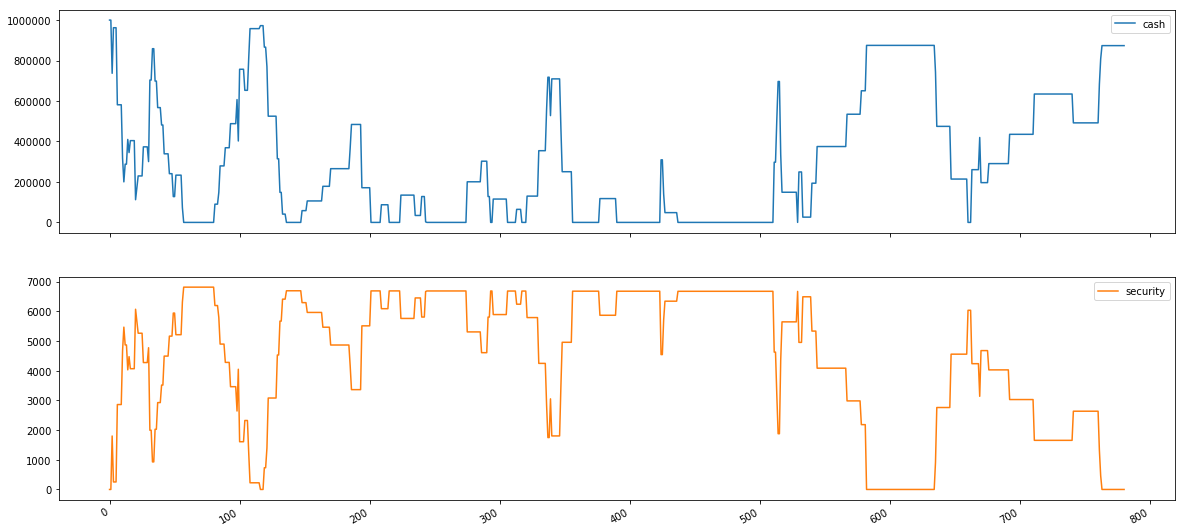

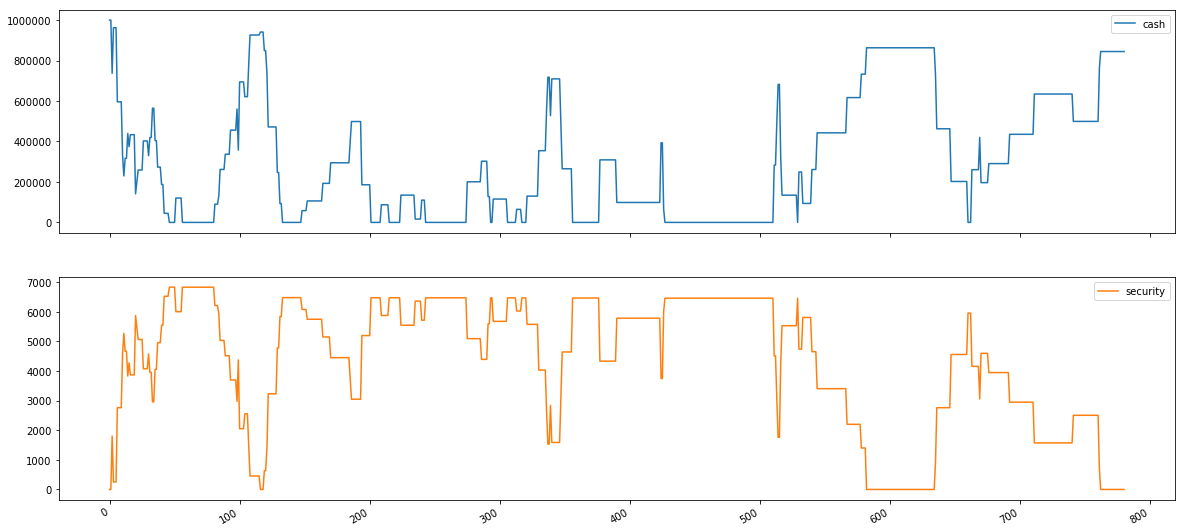

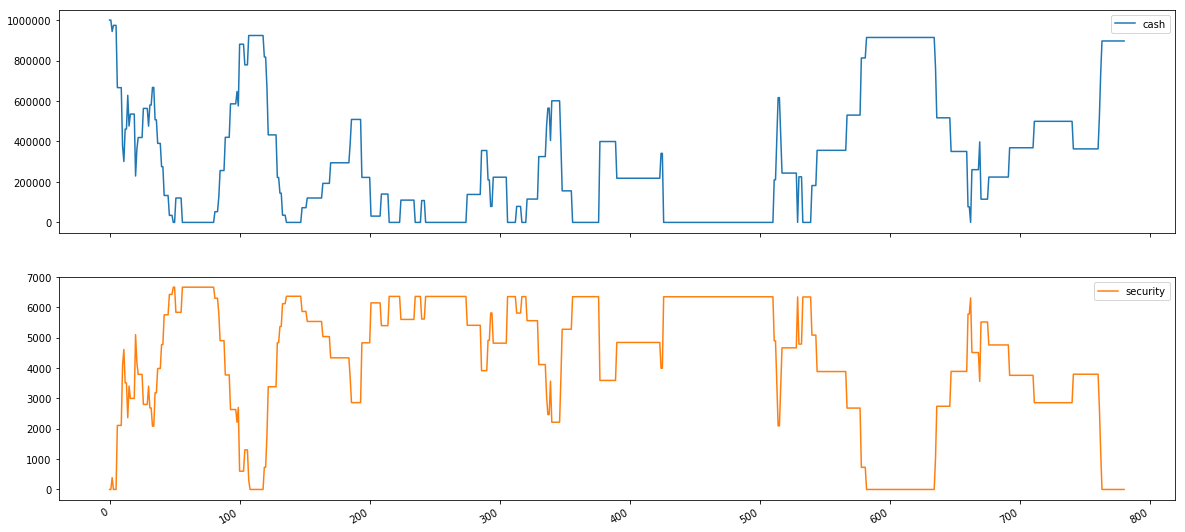

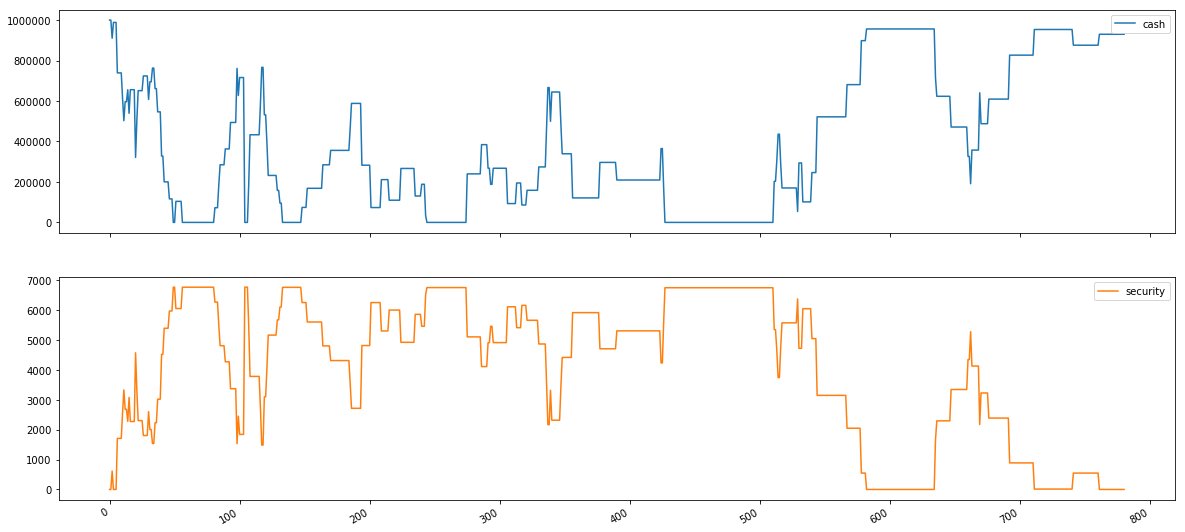

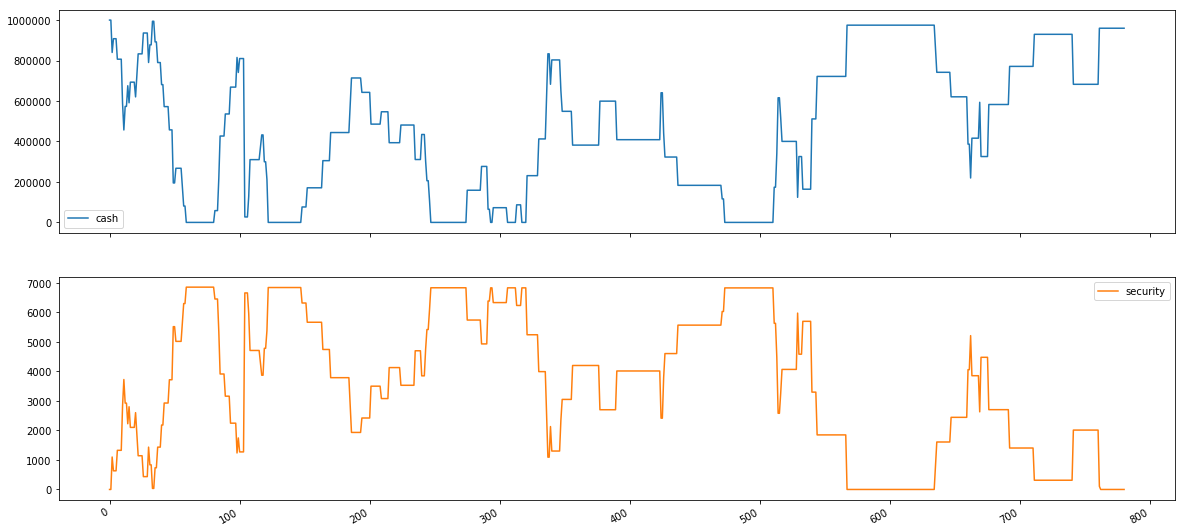

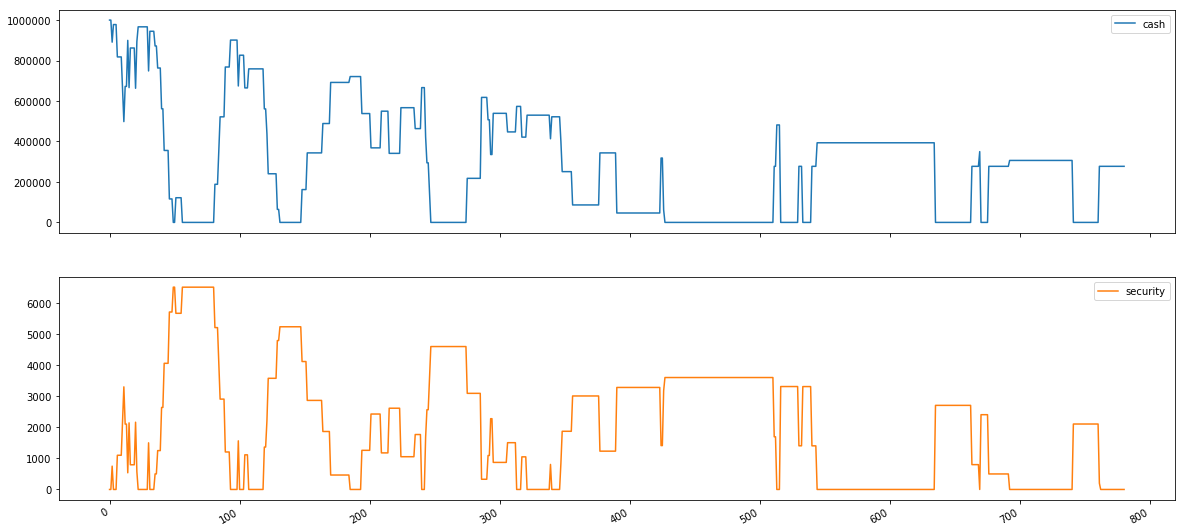

In [146]:
delays = 10.0 ** np.arange(-5, 5)
returns = []
for delay in delays:
    returns.append(plot_portfolio('MA', delay))


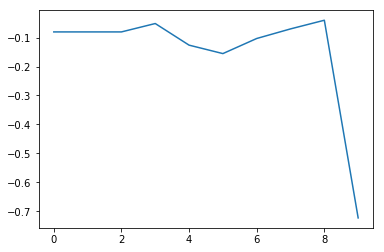

In [147]:
import matplotlib.pyplot as plt
plt.plot(returns)

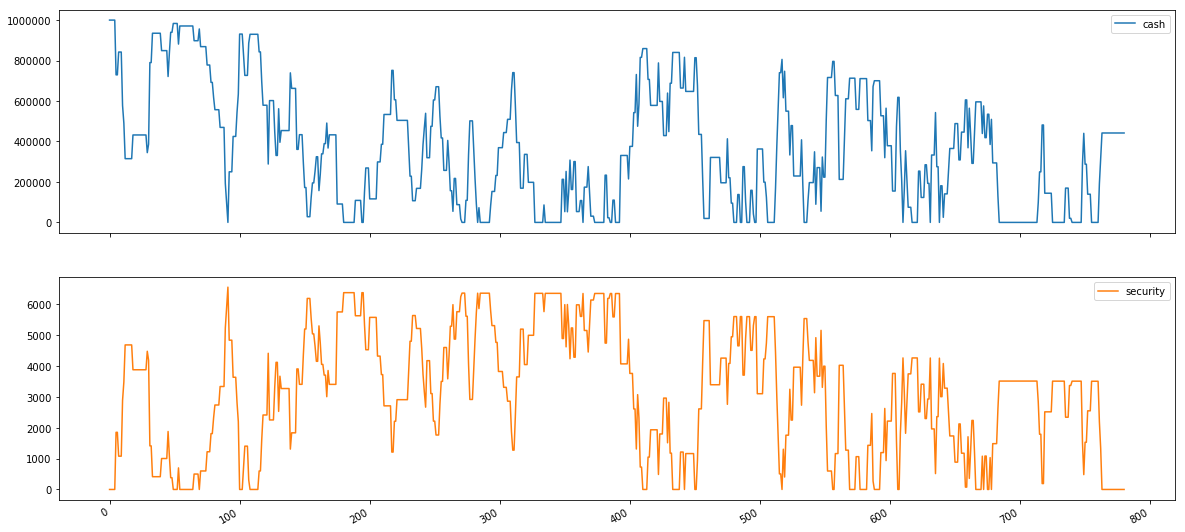

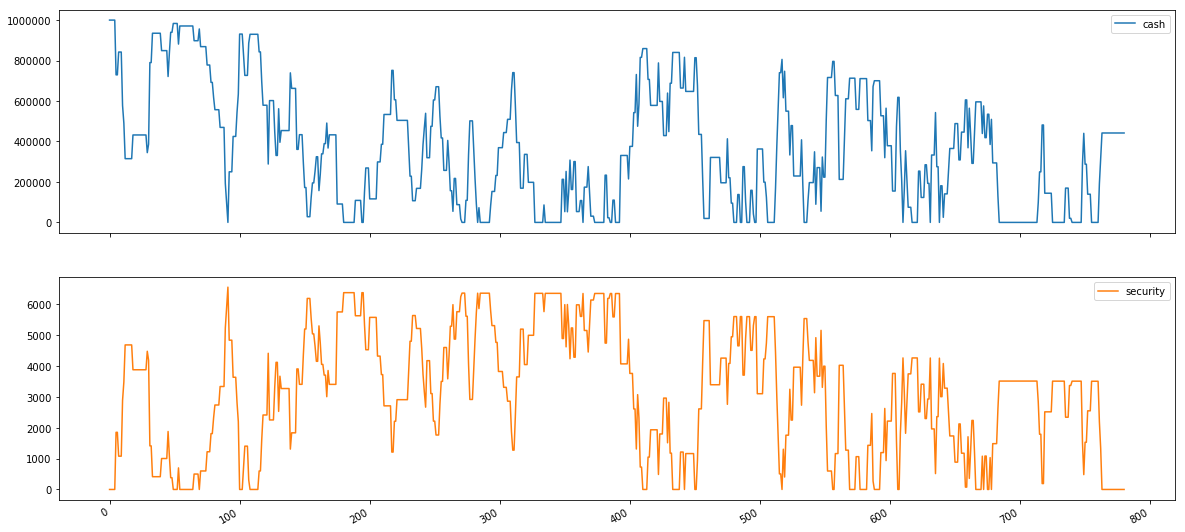

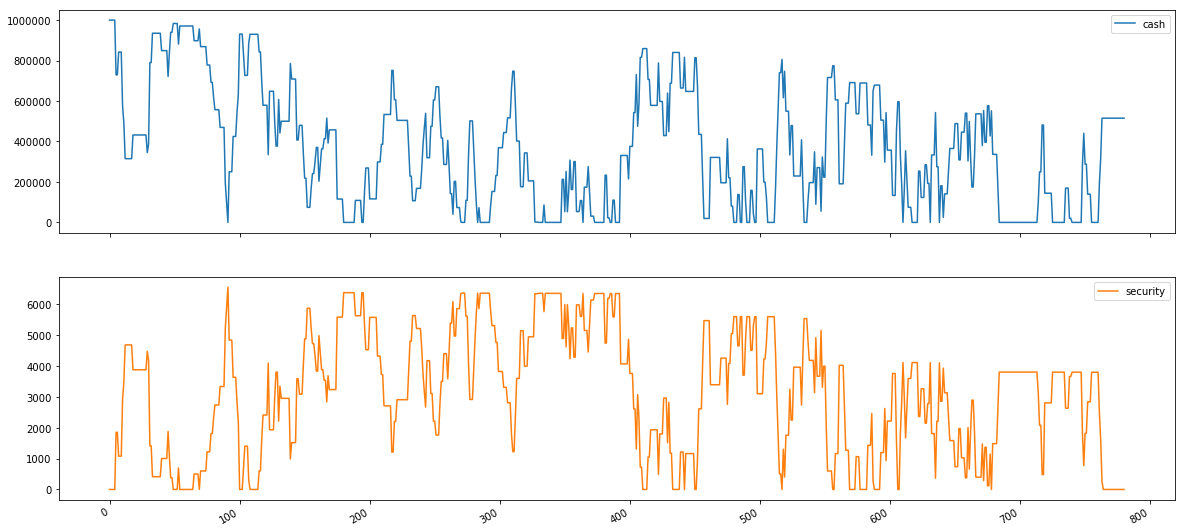

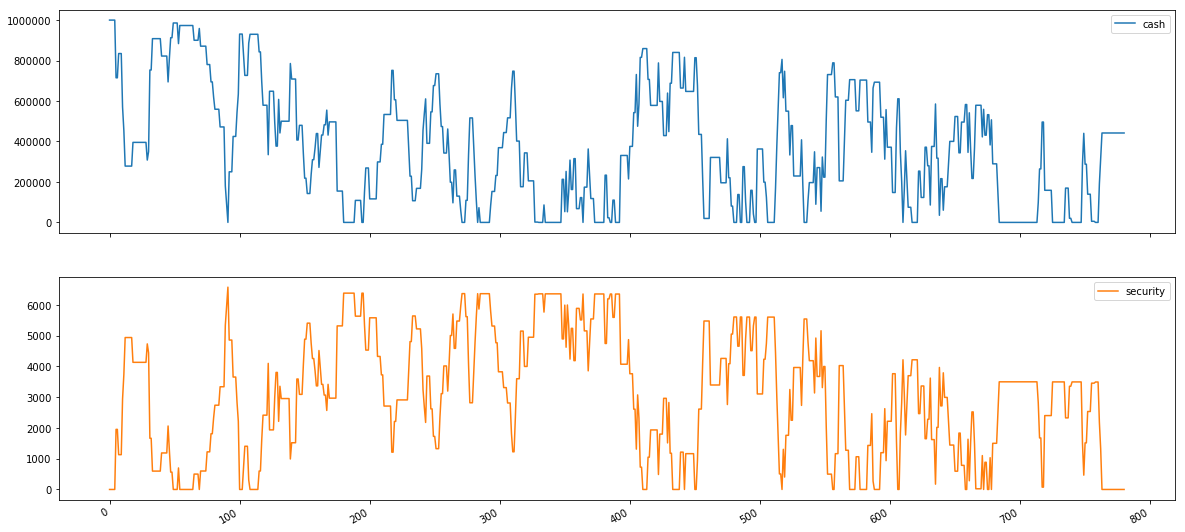

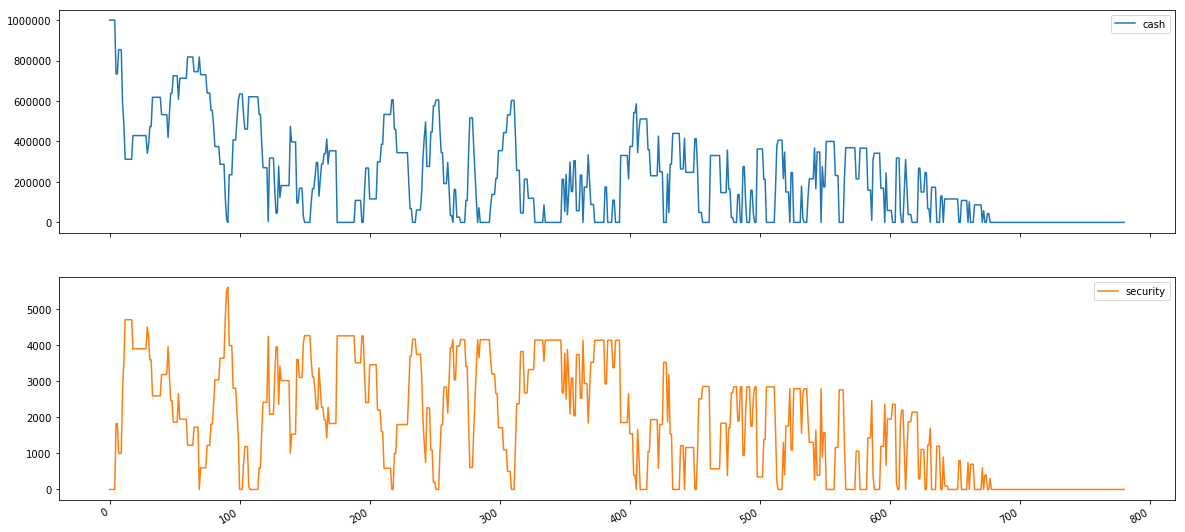

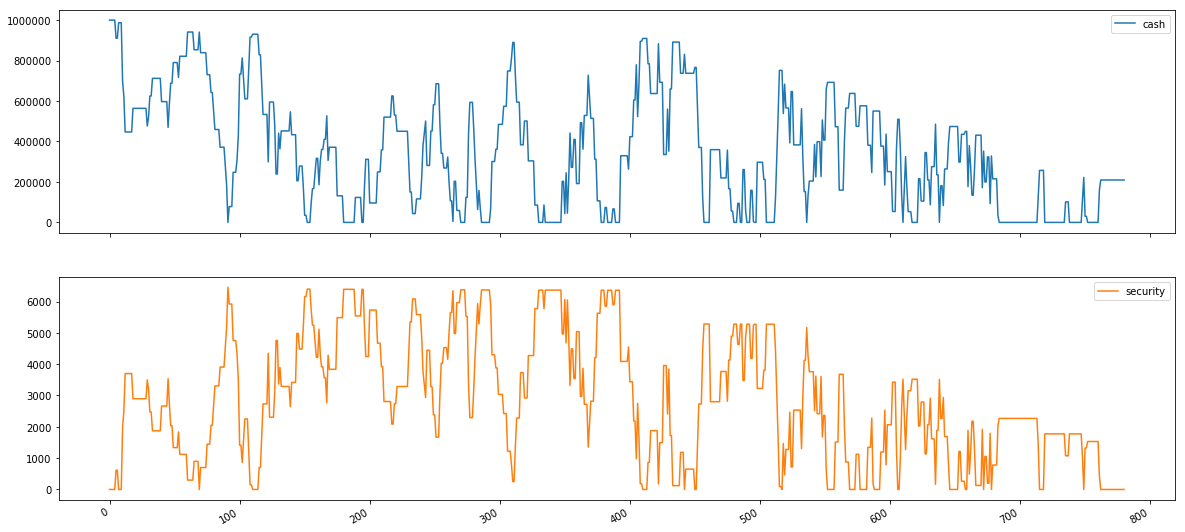

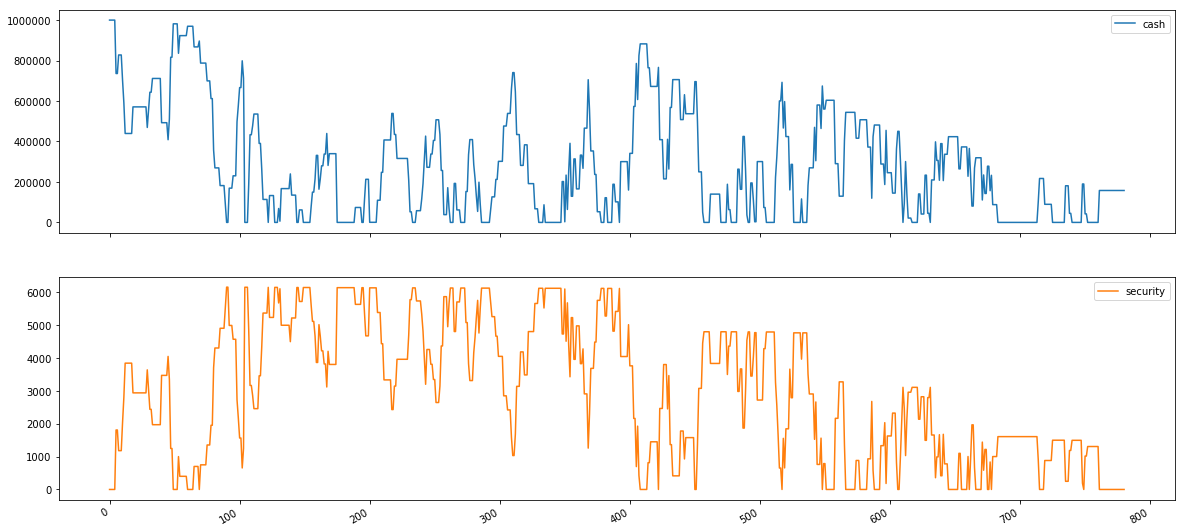

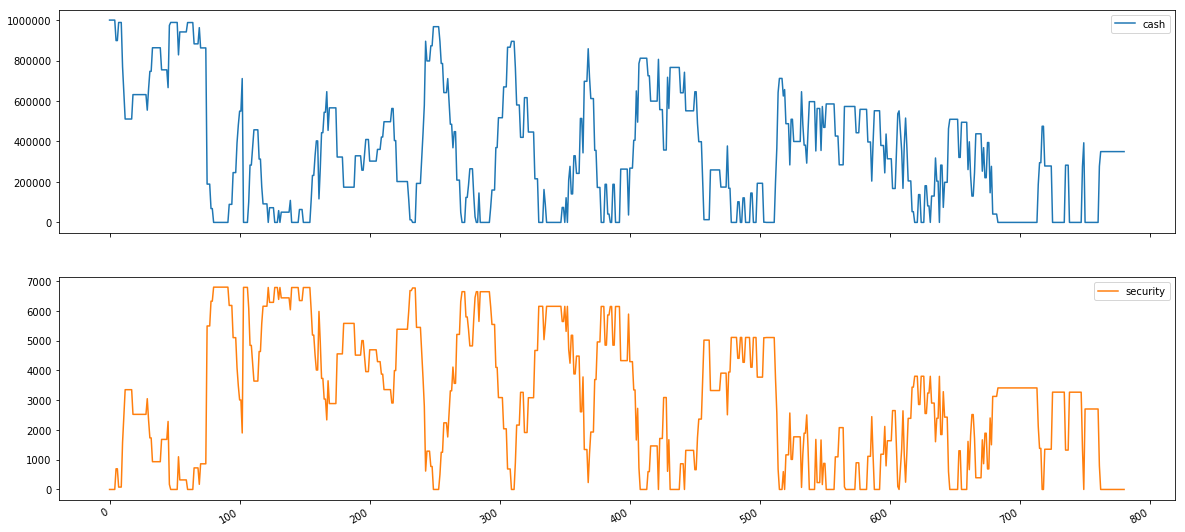

In [148]:
delays = 10.0 ** np.arange(-4, 4)
returns = []
for delay in delays:
    returns.append(plot_portfolio('RSI', delay))


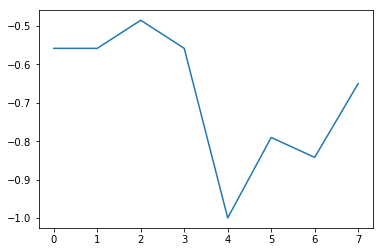

In [149]:
import matplotlib.pyplot as plt
plt.plot(returns)

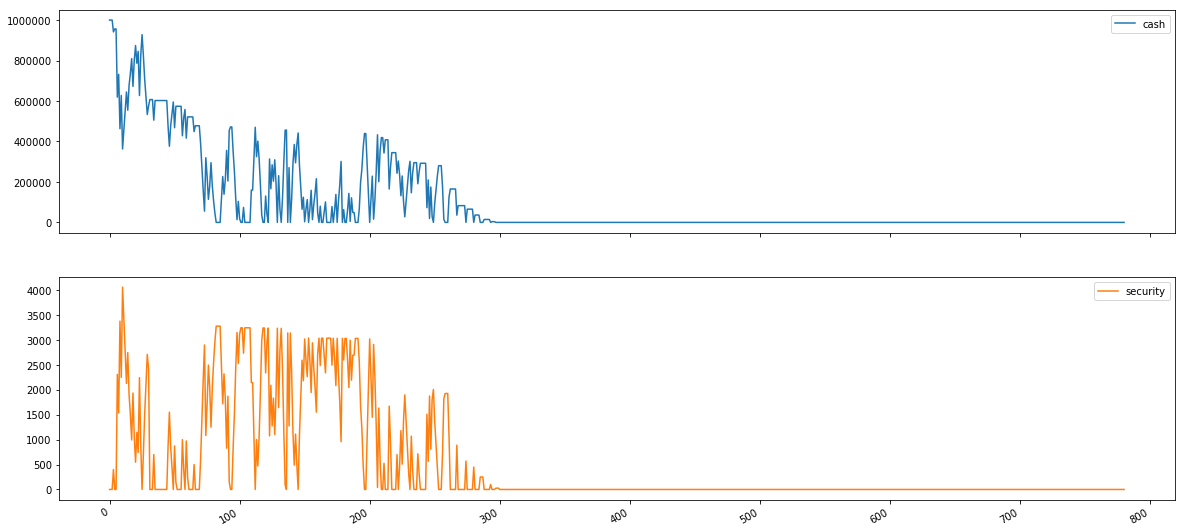

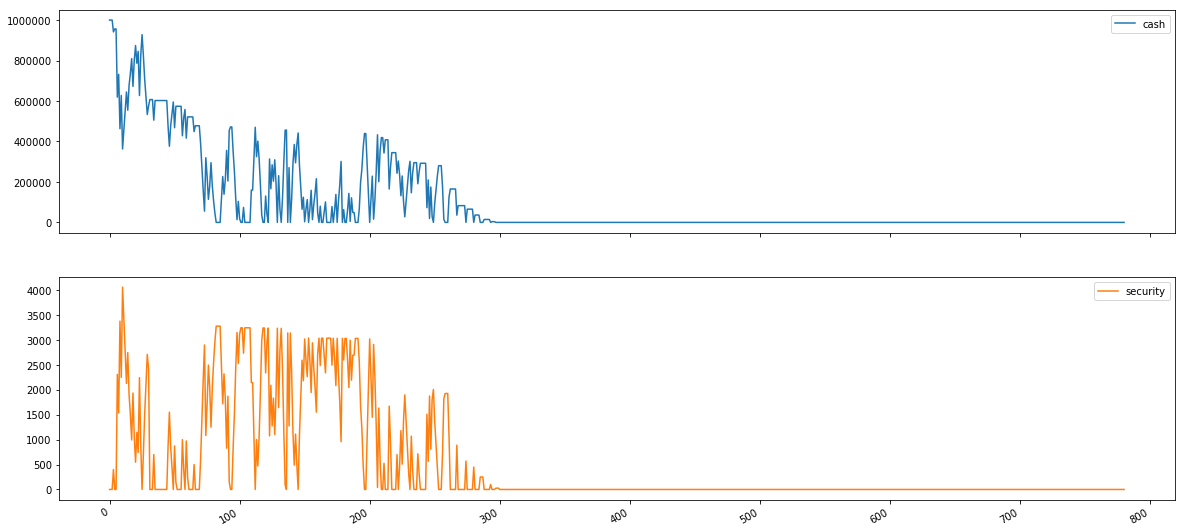

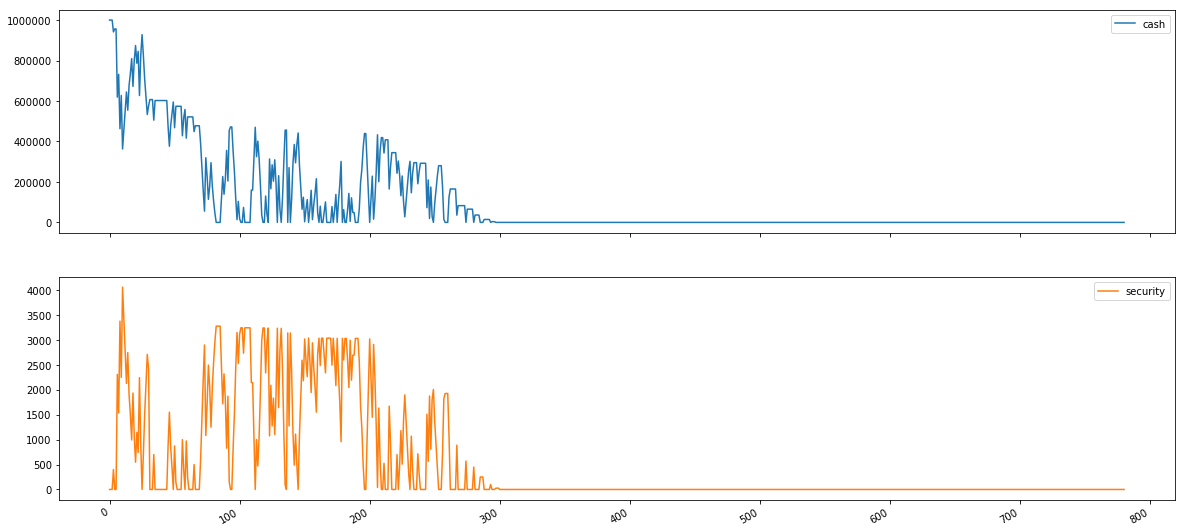

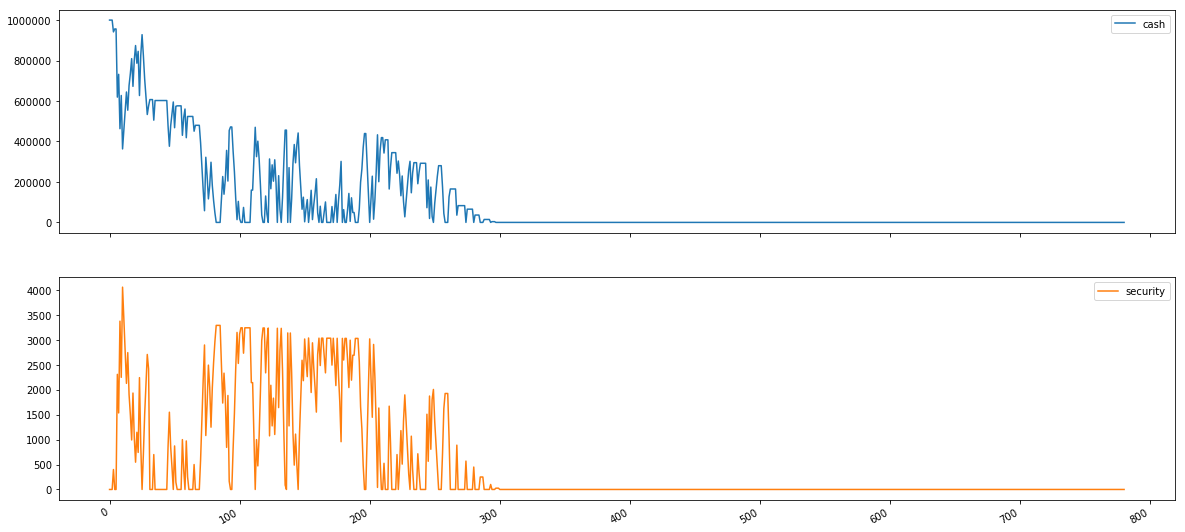

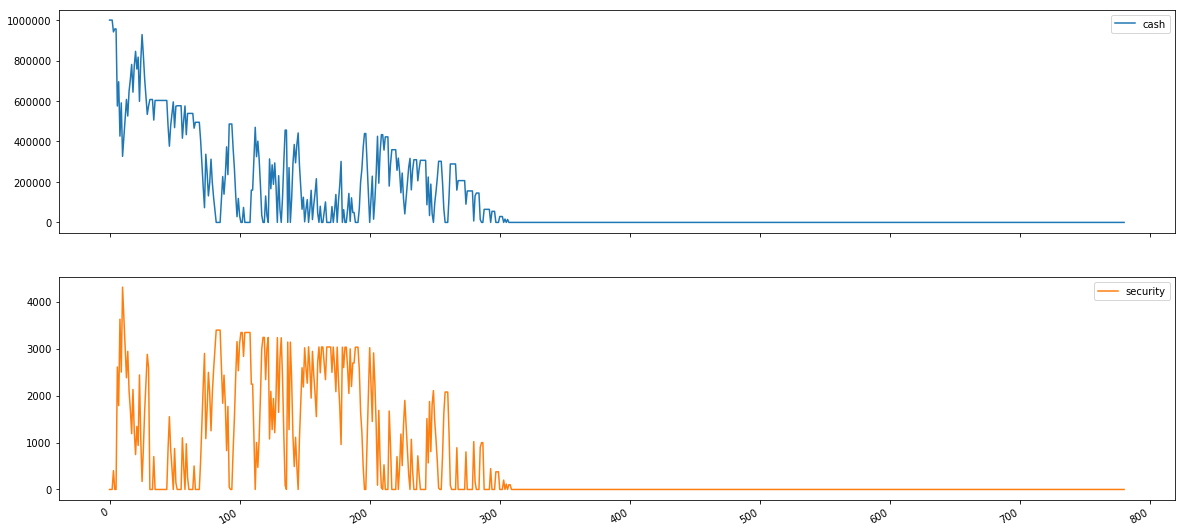

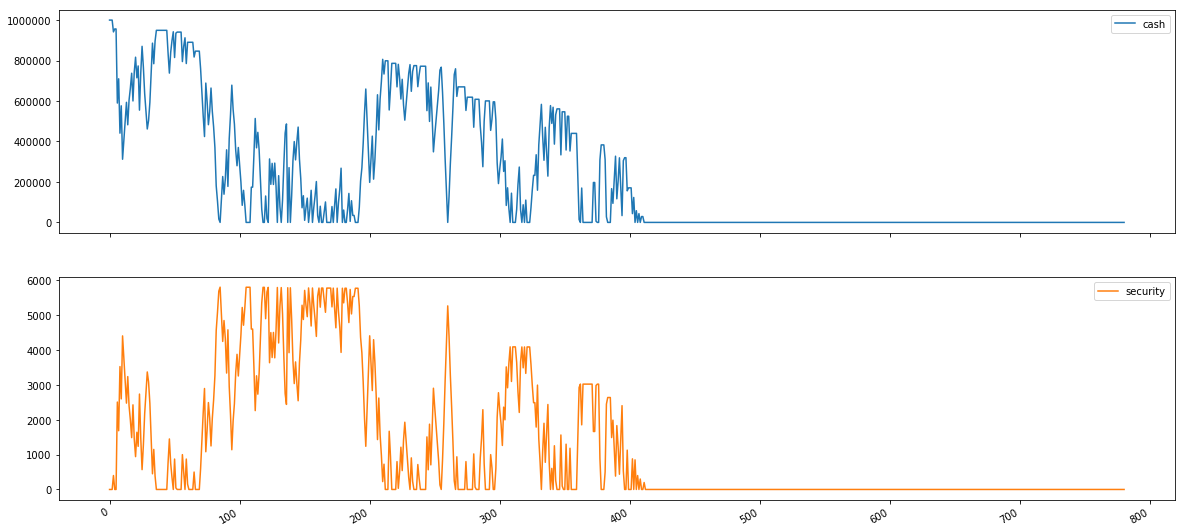

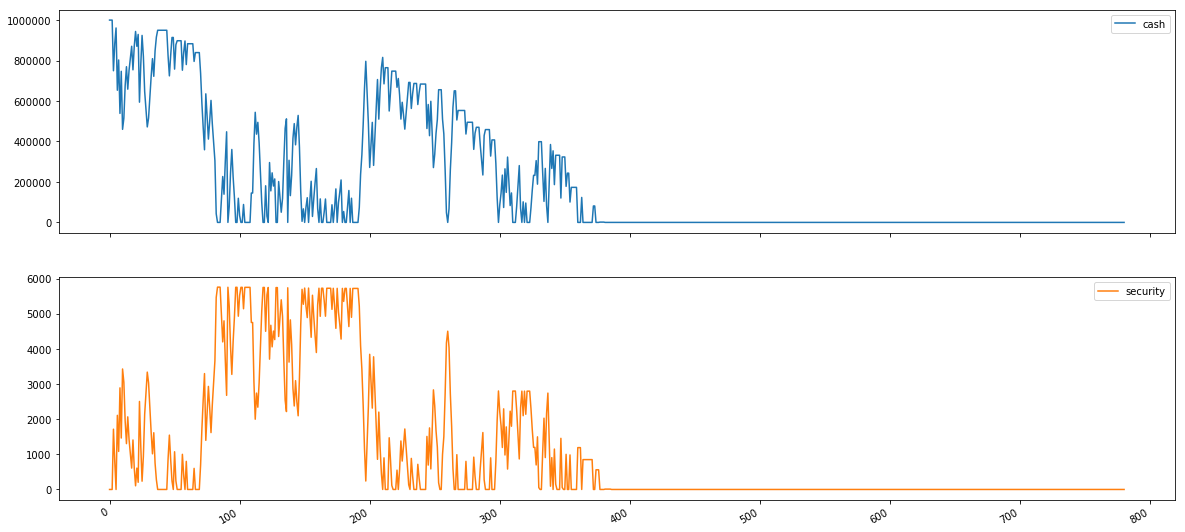

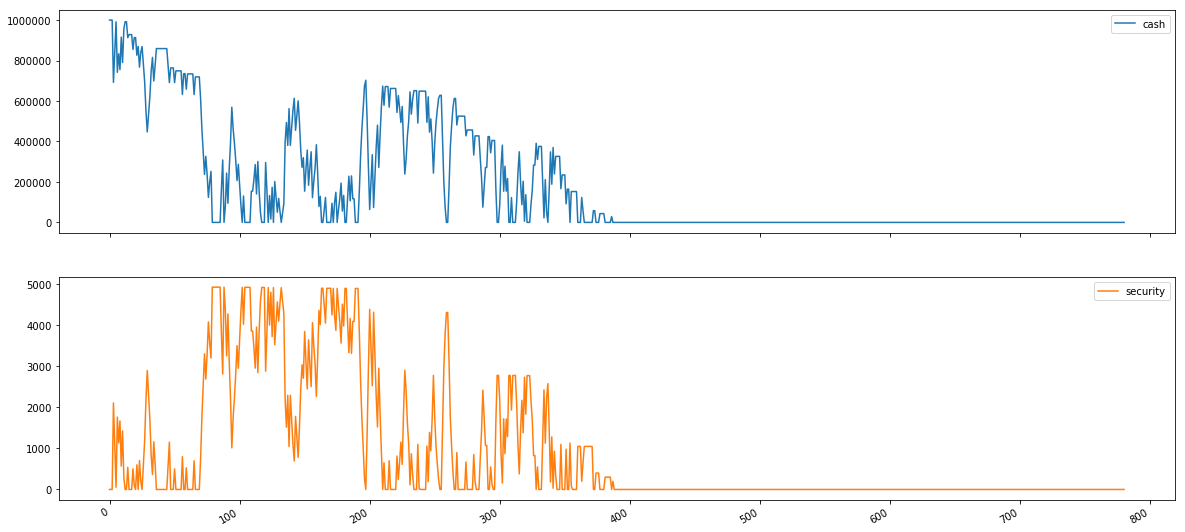

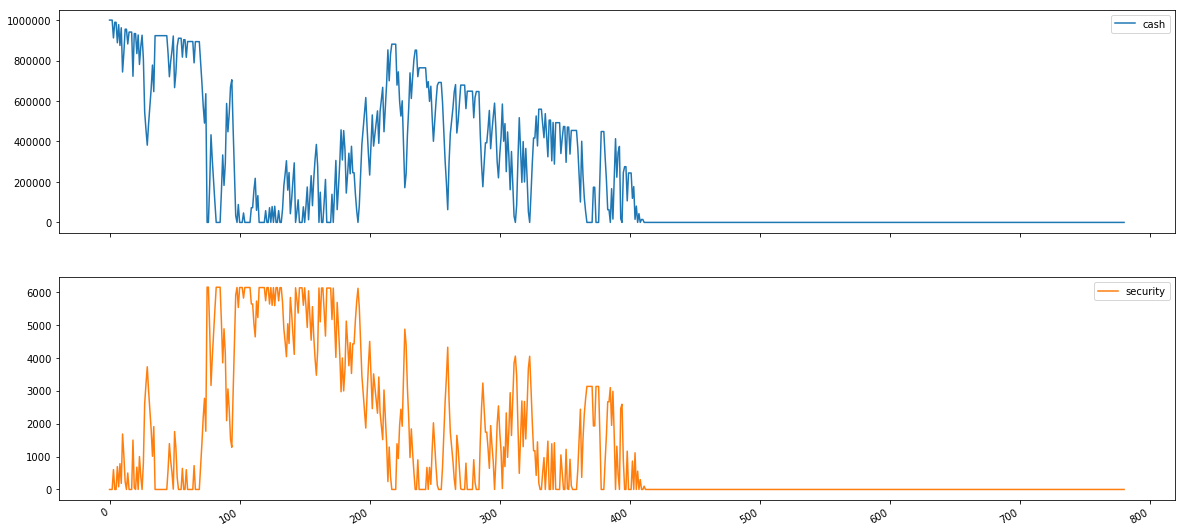

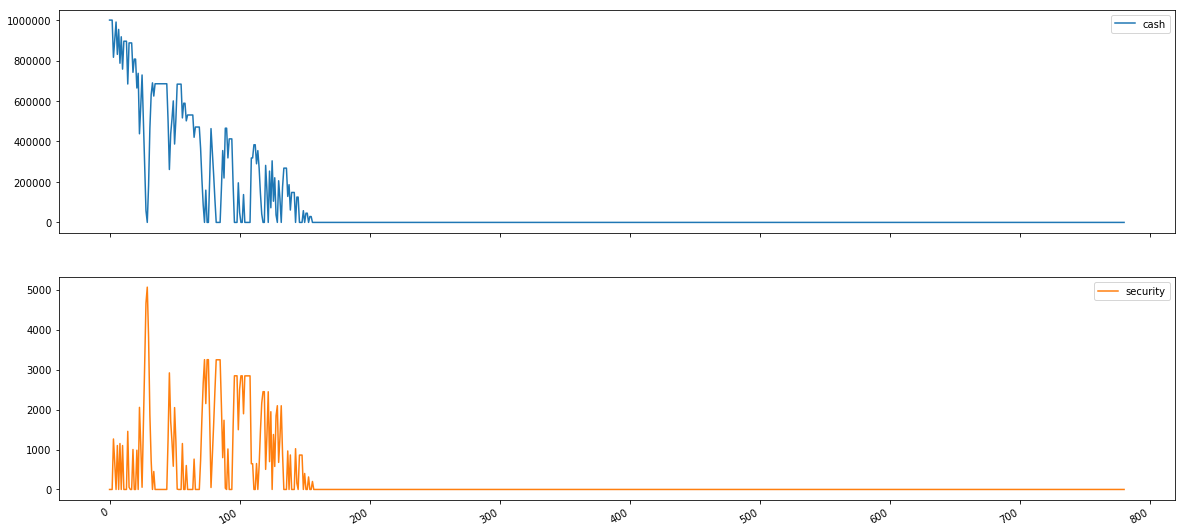

In [150]:
delays = 10.0 ** np.arange(-5, 5)
returns = []
for delay in delays:
    returns.append(plot_portfolio('MP', delay))


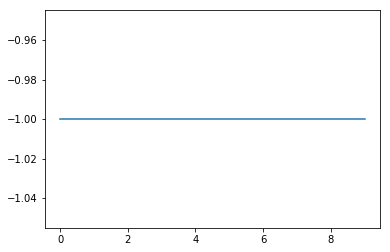

In [151]:
import matplotlib.pyplot as plt
plt.plot(returns)